# Import libraries

In [85]:
import os
from skimage import io, color, transform, exposure, feature,filters, draw
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import json


import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.applications import VGG16
from keras.models import Model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout
from keras.layers import RandomFlip,RandomRotation,RandomZoom

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message="is_sparse is deprecated*", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Getting the image path from each Directory and define DataFrame for image_Path and label for each image

In [2]:
def Create_DataFrame(root_dir):
    Original_image = []
    class_labels = []

    classes = ['Cleavers', 'Common_Chickweed', 'Maize', 'Shepherds_Purse']

    for texture_class in classes:
        class_dir = os.path.join(root_dir, texture_class)
        image_files = sorted([f for f in os.listdir(class_dir) if f.endswith('.png')])

        for image_file in image_files:
            image_path = os.path.join(class_dir, image_file)

            Original_image.append(image_path)

            class_labels.append(texture_class)

    data = pd.DataFrame({'image_Path': Original_image, 'Class': class_labels})

    return data

# set the path for Data
# run Create_DataFrame for this data

In [3]:

Data_directory = 'img'


All_Data=Create_DataFrame(Data_directory)
All_Data

,image_Path,Class
0,img\Cleavers\0.png,Cleavers
1,img\Cleavers\1.png,Cleavers
2,img\Cleavers\10.png,Cleavers
3,img\Cleavers\100.png,Cleavers
4,img\Cleavers\101.png,Cleavers
...,...,...
995,img\Shepherds_Purse\95.png,Shepherds_Purse
996,img\Shepherds_Purse\96.png,Shepherds_Purse
997,img\Shepherds_Purse\97.png,Shepherds_Purse
998,img\Shepherds_Purse\98.png,Shepherds_Purse


# Load the image by the path  and Resize it to 128,128

In [4]:
def preprocess_single_image(images_paths):
    resized_image_array=[]
    Original_image_array=[]

    for image_path in images_paths:

        image = io.imread(image_path)

        new_size = (128, 128, 3)
        resized_image = transform.resize(image, new_size)

        # # Define the target size
        # target_size = (128, 128)
        # # Resize the image to the target size
        # resized_image = transform.resize(image, target_size)


        resized_image_array.append(resized_image)
        Original_image_array.append(image)

    return  resized_image_array,Original_image_array

# path All images path to preprocess_single_image function 

In [5]:
resized_image_array,Original_image_array=preprocess_single_image(All_Data.image_Path)

# Add the original image list and the resized image list to the dataframe 

In [6]:
All_Data["Original_image_array"]=Original_image_array
All_Data["resized_image_array"]=resized_image_array


In [7]:
All_Data

,image_Path,Class,Original_image_array,resized_image_array
0,img\Cleavers\0.png,Cleavers,"[[[82, 61, 41], [85, 64, 45], [84, 65, 47], [8...","[[[0.32264571844362744, 0.24029277726715684, 0..."
1,img\Cleavers\1.png,Cleavers,"[[[81, 51, 34], [81, 51, 34], [78, 49, 32], [7...","[[[0.3232923885005132, 0.21005908267935952, 0...."
2,img\Cleavers\10.png,Cleavers,"[[[86, 64, 41], [88, 66, 43], [85, 63, 39], [8...","[[[0.3356116246629333, 0.24838618029043782, 0...."
3,img\Cleavers\100.png,Cleavers,"[[[91, 71, 58], [92, 71, 58], [80, 57, 44], [8...","[[[0.33941962505972506, 0.2539059891611859, 0...."
4,img\Cleavers\101.png,Cleavers,"[[[61, 44, 32], [62, 45, 33], [61, 45, 31], [5...","[[[0.2342230062524591, 0.17083753996389256, 0...."
...,...,...,...,...
995,img\Shepherds_Purse\95.png,Shepherds_Purse,"[[[88, 63, 43], [89, 62, 42], [92, 66, 47], [9...","[[[0.3484180760939039, 0.24955076289588357, 0...."
996,img\Shepherds_Purse\96.png,Shepherds_Purse,"[[[87, 69, 51], [83, 63, 45], [82, 62, 45], [9...","[[[0.32790803449482886, 0.25387889085937665, 0..."
997,img\Shepherds_Purse\97.png,Shepherds_Purse,"[[[94, 75, 50], [93, 75, 50], [93, 75, 50], [9...","[[[0.3672176585477941, 0.2955571193321079, 0.1..."
998,img\Shepherds_Purse\98.png,Shepherds_Purse,"[[[113, 108, 103], [110, 103, 99], [111, 103, ...","[[[0.4402231253829657, 0.4209982479319853, 0.4..."


# Check the shape for an image before and after resize

In [8]:
first=All_Data.iloc[14]
first

image_Path                                           img\Cleavers\110.png
Class                                                            Cleavers
Original_image_array    [[[163, 169, 175], [163, 169, 177], [165, 170,...
resized_image_array     [[[0.6431868825667384, 0.666035760236831, 0.69...
Name: 14, dtype: object

In [9]:
first.Original_image_array.shape

(275, 275, 3)

In [10]:
first.resized_image_array.shape

(128, 128, 3)

# Visualize one example , Display the original image and the resized image 

In [11]:
def Polt_image_Ex(first_row):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 4, 1)
    plt.imshow(first_row.Original_image_array, cmap='gray')
    plt.title("Original Image")

    plt.subplot(1, 4, 2)
    plt.imshow(first_row.resized_image_array, cmap='gray')
    plt.title("Resized Image")

  

    plt.show()

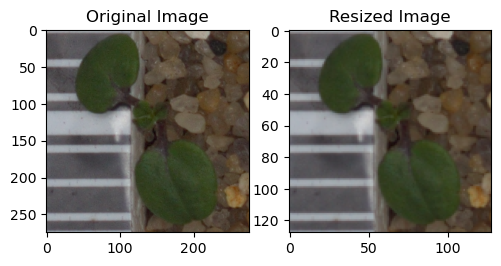

In [12]:
Polt_image_Ex(first)

# Split your data into training (70%), validation (15%), and test (15%) sets with stratification.

In [13]:

X_train, X_temp, y_train, y_temp = train_test_split(All_Data.resized_image_array, All_Data.Class, test_size=0.3, random_state=42, stratify= All_Data.Class)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [14]:
X_train.shape

(700,)

In [15]:
y_train.shape

(700,)

In [16]:
X_train.iloc[0].shape

(128, 128, 3)

# 3.1

## Classification Network

###  VGG-16
### Import VGG net but without the top fully connected layer

In [17]:
input_shape = (128, 128, 3)  
vgg_model = VGG16(weights='imagenet'
                  , include_top=False,
                  input_shape=input_shape)


### print the model Summary

In [18]:
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

### Add new output layer

In [19]:
vgg_model.layers[-1]

### Freeze the first 2 blocks of VGG-16

In [20]:
for layer in vgg_model.layers:
    layer.trainable = False

### Define the new layers

In [21]:
x = vgg_model.get_layer('block2_pool').output
x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
# x = Dense(128, activation='relu')(x)
x = Dense(4, activation='softmax')(x)  # 4 classes for the number of leaves


### Add the New layer to the model

In [22]:
vgg_model_transfer = Model(inputs=vgg_model.input, outputs=x)

### Print the model Summary after add new output layer

In [23]:
vgg_model_transfer.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

### Encode the class label before path to VGG-16

In [24]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_valid_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)


### Convert the Class Label to Categorical 

In [25]:
nClasses = 4

y_train_k = keras.utils.to_categorical(y_train_encoded, num_classes=nClasses)
y_valid_k = keras.utils.to_categorical(y_valid_encoded, num_classes=nClasses)
y_test_k = keras.utils.to_categorical(y_test_encoded, num_classes=nClasses)

### Define the otimizer and compile the VGG-16 model

In [26]:
batchSize = 32
nEpochs = 10

    
sgd = keras.optimizers.SGD(lr=0.0008)
vgg_model_transfer.compile(loss='categorical_crossentropy', 
                           optimizer=sgd, 
                           metrics=['accuracy'])

c:\Users\ahmed\anaconda3\envs\My_env\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


### check the shape of VGG-16 model

In [27]:
vgg_model_transfer.input_shape

(None, 128, 128, 3)

In [28]:
X_train.values

array([array([[[0.2088583 , 0.14404518, 0.08971139],
               [0.20242328, 0.13528173, 0.08074329],
               [0.18797643, 0.11678233, 0.05958946],
               ...,
               [0.20719132, 0.13241954, 0.10044113],
               [0.21009791, 0.13420943, 0.09801151],
               [0.21071185, 0.13482337, 0.09629702]],

              [[0.21639386, 0.15041654, 0.09704231],
               [0.20892196, 0.1406162 , 0.0866917 ],
               [0.19235134, 0.120134  , 0.06308211],
               ...,
               [0.20267543, 0.12585718, 0.09285554],
               [0.20728287, 0.12906596, 0.09170383],
               [0.20893369, 0.13071678, 0.09102622]],

              [[0.23673562, 0.16933211, 0.11813725],
               [0.22713994, 0.15768995, 0.10533088],
               [0.20618095, 0.13351315, 0.07730156],
               ...,
               [0.19691318, 0.11592736, 0.08074826],
               [0.20415602, 0.1213282 , 0.0816736 ],
               [0.2073667 , 0.12453

### stack X_train ,X_val and X_test

In [29]:
X_train_stack = np.stack(X_train.values, axis=0)

X_val_stack = np.stack(X_val.values, axis=0)

X_test_stack = np.stack(X_test.values, axis=0) 


In [30]:
print(X_train_stack.dtype)
print(X_train_stack.shape)

float64
(700, 128, 128, 3)


### fit VGG-16 model with the data 

In [31]:

history = vgg_model_transfer.fit(X_train_stack, y_train_k, batch_size=batchSize, epochs=nEpochs, verbose=1, 
                                 validation_data=(X_val_stack, y_valid_k))

Epoch 1/10
22/22 [==============================] - 33s 1s/step - loss: 4.3170 - accuracy: 0.3229 - val_loss: 1.4207 - val_accuracy: 0.3533
Epoch 2/10
22/22 [==============================] - 32s 1s/step - loss: 1.1871 - accuracy: 0.4743 - val_loss: 1.3833 - val_accuracy: 0.3933
Epoch 3/10
22/22 [==============================] - 38s 2s/step - loss: 0.9906 - accuracy: 0.5800 - val_loss: 1.3469 - val_accuracy: 0.4467
Epoch 4/10
22/22 [==============================] - 37s 2s/step - loss: 0.8026 - accuracy: 0.6786 - val_loss: 1.3084 - val_accuracy: 0.4933
Epoch 5/10
22/22 [==============================] - 31s 1s/step - loss: 0.6632 - accuracy: 0.7843 - val_loss: 1.3841 - val_accuracy: 0.4333
Epoch 6/10
22/22 [==============================] - 29s 1s/step - loss: 0.5449 - accuracy: 0.8271 - val_loss: 1.2394 - val_accuracy: 0.5067
Epoch 7/10
22/22 [==============================] - 29s 1s/step - loss: 0.4357 - accuracy: 0.8871 - val_loss: 1.2306 - val_accuracy: 0.5467
Epoch 8/10
22/22 [==

### Plot training & validation accuracy values and loss

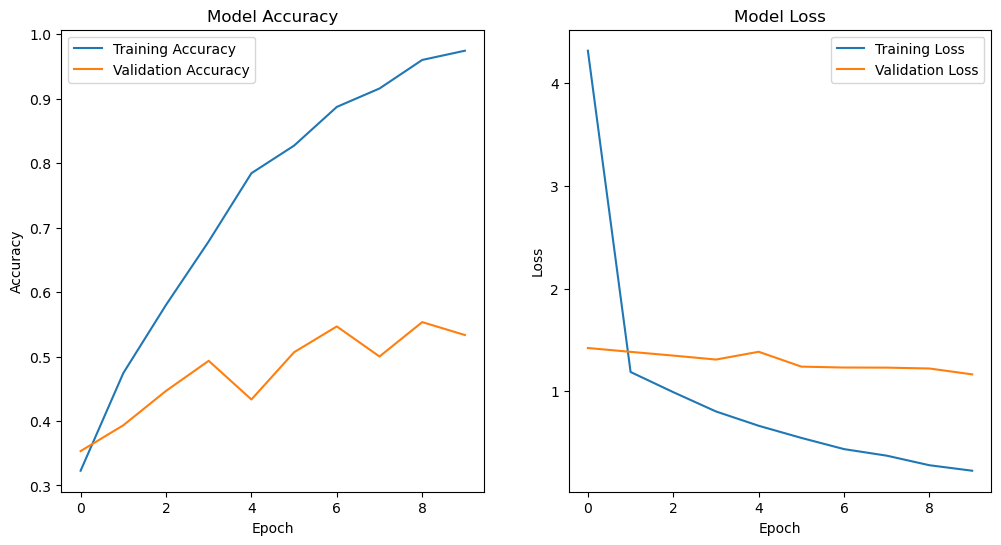

In [32]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Evaluate The VGG-16 model on the testing sets

In [33]:
y_predict_prob = vgg_model_transfer.predict(X_test_stack)

5/5 [==============================] - 5s 941ms/step


In [34]:
y_predict = y_predict_prob.argmax(axis=-1)

In [35]:
conf_mx = confusion_matrix(y_test_encoded, y_predict)
print('Confusion matrix For Test: \n{0}'.format(conf_mx))

Confusion matrix For Test: 
[[10  8  6 14]
 [ 3 15  3 16]
 [ 0  1 33  4]
 [ 3  5  3 26]]


### Evaluate The VGG-16 model on the training sets

In [36]:
y_predict_prob_train = vgg_model_transfer.predict(X_train_stack)
y_predict_train = y_predict_prob_train.argmax(axis=-1)

conf_mx_train = confusion_matrix(y_train_encoded, y_predict_train)
print('Confusion matrix For Train: \n{0}'.format(conf_mx_train))

22/22 [==============================] - 20s 921ms/step
Confusion matrix For Train: 
[[164   1   2   8]
 [  0 175   0   0]
 [  0   0 175   0]
 [  1   0   0 174]]


### Evaluate The VGG-16 model on the validation sets

In [37]:
y_predict_prob_val = vgg_model_transfer.predict(X_val_stack)
y_predict_val = y_predict_prob_val.argmax(axis=-1)

conf_mx_val = confusion_matrix(y_valid_encoded, y_predict_val)
print('Confusion matrix For Validation: \n{0}'.format(conf_mx_val))

5/5 [==============================] - 5s 949ms/step
Confusion matrix For Validation: 
[[14  4  9 10]
 [ 2 20  1 15]
 [ 5  5 23  4]
 [ 3  8  4 23]]


# 3.2

## Regression Network

### Load the JSON file

In [38]:
with open('bbox.json', 'r') as json_file:
    bounding_box_data = json.load(json_file)

### Read images path and their height and width from the json file and save them in DataFrame

In [39]:
def Read_images_with_H_W(root_dir,bounding_box_data):


    images = []
    heights = []
    widths = []
    Original_image_2=[]
    class_labels_2=[]
    # Loop through bounding_box_data
    for class_name, class_data in bounding_box_data.items():

        class_dir = os.path.join(root_dir, class_name)
        image_files = [f for f in os.listdir(class_dir) if f.endswith('.png')]

        # Sort based on filename
        image_files.sort(key=lambda x: int(x.split('.')[0]))
        
        for image_file in image_files:
            image_path = os.path.join(class_dir, image_file)

            Original_image_2.append(image_path)
            class_labels_2.append(class_name)

        for image_name, bbox_info in class_data.items():
            
            height = bbox_info['height']
            width = bbox_info['width']

            images.append(image_name)

           
            heights.append(height)
            widths.append(width)

    data = pd.DataFrame({'image_Path': Original_image_2, 'Class': class_labels_2,'Image_name':images,'height':heights,'width':widths})
    return data

### Run Read_images_with_H_W function With dir path and json file

In [40]:
root_dir='img'
DF_Img_H_W=Read_images_with_H_W(root_dir,bounding_box_data)

In [41]:
DF_Img_H_W

,image_Path,Class,Image_name,height,width
0,img\Common_Chickweed\0.png,Common_Chickweed,0,457,426
1,img\Common_Chickweed\1.png,Common_Chickweed,1,217,88
2,img\Common_Chickweed\2.png,Common_Chickweed,2,63,40
3,img\Common_Chickweed\3.png,Common_Chickweed,3,87,61
4,img\Common_Chickweed\4.png,Common_Chickweed,4,472,237
...,...,...,...,...,...
995,img\Shepherds_Purse\245.png,Shepherds_Purse,245,474,405
996,img\Shepherds_Purse\246.png,Shepherds_Purse,246,38,52
997,img\Shepherds_Purse\247.png,Shepherds_Purse,247,99,64
998,img\Shepherds_Purse\248.png,Shepherds_Purse,248,134,134


### Read all images by their path

In [42]:
def preprocess_single_image(images_paths):
    Original_image_array=[]

    for image_path in images_paths:

        image = io.imread(image_path)
        Original_image_array.append(image)

    return  Original_image_array

### Add images array list to DataFrame 

In [43]:
Original_image_array=preprocess_single_image(DF_Img_H_W.image_Path)
DF_Img_H_W["Original_image_array"]=Original_image_array

In [44]:
DF_Img_H_W.head()

,image_Path,Class,Image_name,height,width,Original_image_array
0,img\Common_Chickweed\0.png,Common_Chickweed,0,457,426,"[[[92, 74, 64], [90, 72, 62], [90, 71, 61], [8..."
1,img\Common_Chickweed\1.png,Common_Chickweed,1,217,88,"[[[144, 142, 145], [142, 140, 143], [141, 138,..."
2,img\Common_Chickweed\2.png,Common_Chickweed,2,63,40,"[[[93, 76, 62], [96, 78, 65], [95, 78, 65], [1..."
3,img\Common_Chickweed\3.png,Common_Chickweed,3,87,61,"[[[105, 83, 65], [101, 79, 60], [93, 71, 52], ..."
4,img\Common_Chickweed\4.png,Common_Chickweed,4,472,237,"[[[95, 83, 66], [81, 66, 47], [80, 61, 42], [8..."


### Normalize the height and width corresponding to the image size

In [45]:
def Normalize_height(Original_image,original_heights,original_widths):
    normalized_heights=[]
    normalized_widths=[]

    for index, image in enumerate(Original_image):
        image_height, image_width, channels = image.shape
        normalized_heights.append(original_heights[index]/image_height)
        normalized_widths.append(original_widths[index]/image_width)
        
    return normalized_heights,normalized_widths


In [46]:
normalized_heights,normalized_widths=Normalize_height(DF_Img_H_W.Original_image_array,DF_Img_H_W.height,DF_Img_H_W.width)

### Add normalized_heights and normalized_widths list to DataFrame

In [47]:
DF_Img_H_W["normalized_heights"]=normalized_heights
DF_Img_H_W["normalized_widths"]=normalized_widths


### Resize the original image to (128,128) and to DataFrame

In [48]:
def resize_Image(Original_image_array):
    new_size = (128, 128, 3)
    return transform.resize(Original_image_array, new_size)

In [49]:
DF_Img_H_W["Resized_image"]=DF_Img_H_W['Original_image_array'].apply(resize_Image)

In [50]:
DF_Img_H_W.head()

,image_Path,Class,Image_name,height,width,Original_image_array,normalized_heights,normalized_widths,Resized_image
0,img\Common_Chickweed\0.png,Common_Chickweed,0,457,426,"[[[92, 74, 64], [90, 72, 62], [90, 71, 61], [8...",0.966173,0.900634,"[[[0.36511894202935075, 0.29846823974770337, 0..."
1,img\Common_Chickweed\1.png,Common_Chickweed,1,217,88,"[[[144, 142, 145], [142, 140, 143], [141, 138,...",0.931330,0.377682,"[[[0.5379098686336062, 0.5236453579738803, 0.5..."
2,img\Common_Chickweed\2.png,Common_Chickweed,2,63,40,"[[[93, 76, 62], [96, 78, 65], [95, 78, 65], [1...",0.797468,0.506329,"[[[0.36988100538066787, 0.30396495145909924, 0..."
3,img\Common_Chickweed\3.png,Common_Chickweed,3,87,61,"[[[105, 83, 65], [101, 79, 60], [93, 71, 52], ...",0.844660,0.592233,"[[[0.413754332299326, 0.32709685680912987, 0.2..."
4,img\Common_Chickweed\4.png,Common_Chickweed,4,472,237,"[[[95, 83, 66], [81, 66, 47], [80, 61, 42], [8...",0.967213,0.485656,"[[[0.2951522038011548, 0.2266123456133386, 0.1..."


### Merge height and width in one column

In [51]:
def add_width_height_column(height,width):
    height_and_width = list(zip(height,width))
    return height_and_width

# Add 'width_height' column to multiple dataframes
DF_Img_H_W["height_and_width"]=add_width_height_column(DF_Img_H_W.normalized_heights,DF_Img_H_W.normalized_widths)


In [52]:
DF_Img_H_W.head()

,image_Path,Class,Image_name,height,width,Original_image_array,normalized_heights,normalized_widths,Resized_image,height_and_width
0,img\Common_Chickweed\0.png,Common_Chickweed,0,457,426,"[[[92, 74, 64], [90, 72, 62], [90, 71, 61], [8...",0.966173,0.900634,"[[[0.36511894202935075, 0.29846823974770337, 0...","(0.9661733615221987, 0.9006342494714588)"
1,img\Common_Chickweed\1.png,Common_Chickweed,1,217,88,"[[[144, 142, 145], [142, 140, 143], [141, 138,...",0.931330,0.377682,"[[[0.5379098686336062, 0.5236453579738803, 0.5...","(0.9313304721030042, 0.3776824034334764)"
2,img\Common_Chickweed\2.png,Common_Chickweed,2,63,40,"[[[93, 76, 62], [96, 78, 65], [95, 78, 65], [1...",0.797468,0.506329,"[[[0.36988100538066787, 0.30396495145909924, 0...","(0.7974683544303798, 0.5063291139240507)"
3,img\Common_Chickweed\3.png,Common_Chickweed,3,87,61,"[[[105, 83, 65], [101, 79, 60], [93, 71, 52], ...",0.844660,0.592233,"[[[0.413754332299326, 0.32709685680912987, 0.2...","(0.8446601941747572, 0.5922330097087378)"
4,img\Common_Chickweed\4.png,Common_Chickweed,4,472,237,"[[[95, 83, 66], [81, 66, 47], [80, 61, 42], [8...",0.967213,0.485656,"[[[0.2951522038011548, 0.2266123456133386, 0.1...","(0.9672131147540983, 0.48565573770491804)"


###  Split your data into training (70%), validation (15%), and test (15%) sets with stratification.

In [53]:
train_data, test_data = train_test_split(DF_Img_H_W, test_size=0.3, random_state=42,stratify= DF_Img_H_W.Class)
val_data, test_data = train_test_split(test_data, test_size=0.5, random_state=42,stratify= test_data.Class)


### pick Resized_image column from DataFrame

In [54]:
train_images=train_data["Resized_image"]
val_images=val_data["Resized_image"]
test_images=test_data["Resized_image"]


In [55]:
train_images

647    [[[0.4027217195298284, 0.36382005575197307, 0....
770    [[[0.41015421557016124, 0.2996216419166275, 0....
879    [[[0.3537724525741287, 0.2824795594955401, 0.2...
918    [[[0.4433355065475155, 0.32769766388126575, 0....
497    [[[0.37871386925554673, 0.3233474287223591, 0....
                             ...                        
749    [[[0.3506564613731172, 0.2606870983987951, 0.1...
372    [[[0.38266196390489154, 0.29798117829415033, 0...
937    [[[0.3575214460784314, 0.3085971607881434, 0.2...
195    [[[0.32045220600457686, 0.26841722617351427, 0...
999    [[[0.29026967964920336, 0.20791673847273284, 0...
Name: Resized_image, Length: 700, dtype: object

### pick height_and_width column from DataFrame to path to the model as a target

In [56]:
train_bboxes = train_data['height_and_width'] 
val_bboxes = val_data['height_and_width']
test_bboxes = test_data['height_and_width']

In [57]:
train_bboxes

647     (0.6733870967741935, 0.9354838709677419)
770     (0.9053254437869822, 0.6449704142011834)
879     (0.9080459770114943, 0.8448275862068966)
918     (0.8010630220197419, 0.9878511769172361)
497     (0.8459016393442623, 0.9475409836065574)
                         ...                    
749     (0.8173758865248227, 0.9716312056737588)
372    (0.9604938271604938, 0.36049382716049383)
937     (0.8117647058823529, 0.4588235294117647)
195     (0.9617224880382775, 0.5430622009569378)
999     (0.7443609022556391, 0.8796992481203008)
Name: height_and_width, Length: 700, dtype: object

### Build regression network

####  VGG-16
#### Import VGG net but without the top fully connected layers. We like to put our own regression layer on top. We will keep VGG net fix and just train our won top layers.

In [58]:
input_shape = (128, 128, 3)  # Adjust input size as needed
vgg_model = VGG16(weights='imagenet'
                  , include_top=False,
                  input_shape=input_shape)

### Freeze the first 2 blocks of VGG-16

In [59]:
for layer in vgg_model.layers:
    layer.trainable = False

In [60]:
New_layer = vgg_model.get_layer('block2_pool').output
New_layer = Conv2D(64, kernel_size=(3, 3), activation='relu')(New_layer)
New_layer = MaxPooling2D(pool_size=(2, 2))(New_layer)
New_layer = Flatten()(New_layer)
New_layer = Dense(128, activation='relu')(New_layer)
New_layer = Dense(64, activation='relu')(New_layer)
New_layer = Dense(2, activation='sigmoid')(New_layer)  # 4 classes for the number of leaves


In [61]:
vgg_regression_model  = Model(inputs=vgg_model.input, outputs=New_layer)

In [62]:
batchSize = 32
nEpochs = 10

    
sgd = keras.optimizers.SGD(lr=0.0008)
vgg_regression_model.compile(loss='mean_squared_error', 
                           optimizer=sgd, 
                           metrics=['accuracy'])

c:\Users\ahmed\anaconda3\envs\My_env\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [63]:

X_train_images = np.stack(train_images.values, axis=0)

X_val_images = np.stack(val_images.values, axis=0)

X_test_images = np.stack(test_images.values, axis=0) 


In [64]:
y_train = np.stack(train_bboxes.values, axis=0)
y_val = np.stack(val_bboxes.values, axis=0)
y_test = np.stack(test_bboxes.values, axis=0)


In [65]:

history_regression = vgg_regression_model.fit(X_train_images, y_train, batch_size=batchSize, epochs=nEpochs, verbose=1, 
                                 validation_data=(X_val_images, y_val))

Epoch 1/10
22/22 [==============================] - 28s 1s/step - loss: 0.1249 - accuracy: 0.5743 - val_loss: 0.0763 - val_accuracy: 0.4867
Epoch 2/10
22/22 [==============================] - 28s 1s/step - loss: 0.0736 - accuracy: 0.5529 - val_loss: 0.0716 - val_accuracy: 0.5133
Epoch 3/10
22/22 [==============================] - 27s 1s/step - loss: 0.0670 - accuracy: 0.5957 - val_loss: 0.0658 - val_accuracy: 0.5333
Epoch 4/10
22/22 [==============================] - 29s 1s/step - loss: 0.0606 - accuracy: 0.6243 - val_loss: 0.0607 - val_accuracy: 0.5533
Epoch 5/10
22/22 [==============================] - 33s 2s/step - loss: 0.0560 - accuracy: 0.6371 - val_loss: 0.0614 - val_accuracy: 0.5933
Epoch 6/10
22/22 [==============================] - 30s 1s/step - loss: 0.0511 - accuracy: 0.6600 - val_loss: 0.0544 - val_accuracy: 0.5867
Epoch 7/10
22/22 [==============================] - 29s 1s/step - loss: 0.0479 - accuracy: 0.6771 - val_loss: 0.0543 - val_accuracy: 0.6333
Epoch 8/10
22/22 [==

### Plot training & validation accuracy values and loss

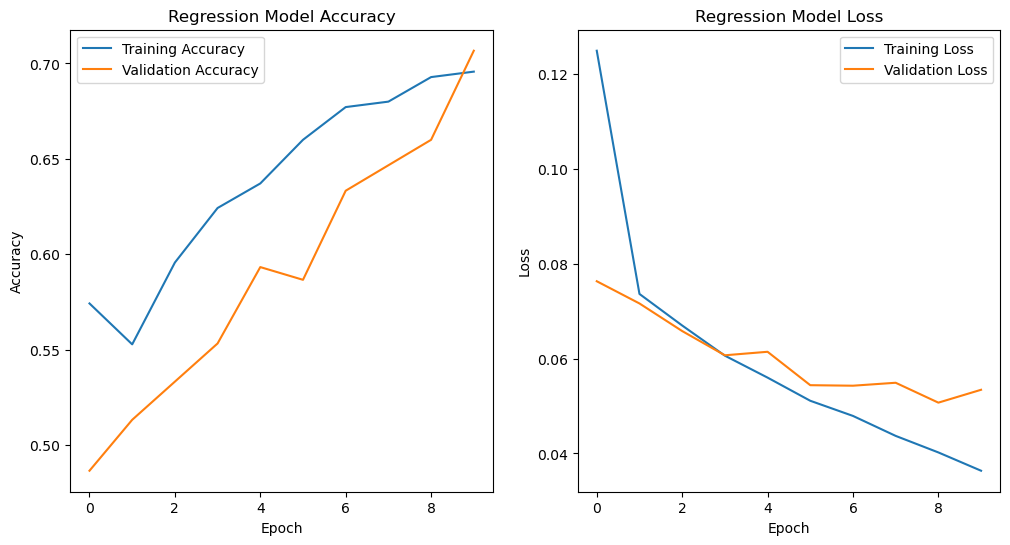

In [66]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_regression.history['accuracy'], label='Training Accuracy')
plt.plot(history_regression.history['val_accuracy'], label='Validation Accuracy')
plt.title('Regression Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_regression.history['loss'], label='Training Loss')
plt.plot(history_regression.history['val_loss'], label='Validation Loss')
plt.title('Regression Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [67]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Load an example image and corresponding true bounding box
example_image = test_images[0]
true_bbox = y_test[0]* 128.0   # Rescale to the original image size (128x128)

# Predict the bounding box using the regression model
predicted_bbox = vgg_regression_model.predict(np.expand_dims(example_image, axis=0))
predicted_bbox = predicted_bbox[0]*128.0  # Rescale to the original image size (128x128)


1/1 [==============================] - 0s 248ms/step


In [68]:
predicted_bbox

array([124.86048,  73.21792], dtype=float32)

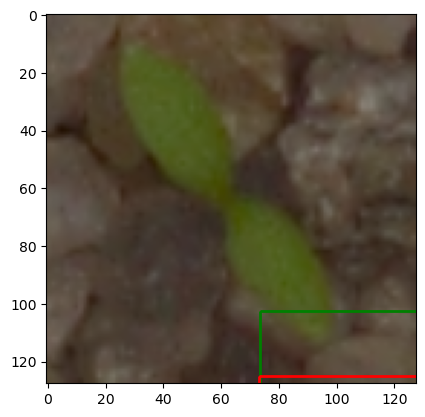

In [69]:

# Create a figure and axis
fig, ax = plt.subplots(1)

# Display the example image
ax.imshow(example_image)

# Plot the true bounding box in green
true_rect = patches.Rectangle(
    (true_bbox[1], true_bbox[0]),  # x, y coordinates
    true_bbox[1],  # width
    true_bbox[0],  # height
    linewidth=2, edgecolor='g', facecolor='none'
)
ax.add_patch(true_rect)

# Plot the predicted bounding box in red
predicted_rect = patches.Rectangle(
    (predicted_bbox[1], predicted_bbox[0]),  # x, y coordinates
    predicted_bbox[1],  # width
    predicted_bbox[0],  # height
    linewidth=2, edgecolor='r', facecolor='none'
)
ax.add_patch(predicted_rect)

# Show the image with bounding boxes
plt.show()


# 4

## Improving the Model

In [2]:
input_shape = (128, 128, 3)  # Adjust input size as needed
vgg_model = VGG16(weights='imagenet'
                  , include_top=False,
                  input_shape=input_shape)

NameError: name 'VGG16' is not defined

In [102]:
for layer in vgg_model.layers:
    layer.trainable = False

In [103]:
data_augmentation = keras.Sequential(
  [
    RandomFlip("horizontal", 
                                                 input_shape=(128, 
                                                              128,
                                                              3)),
    RandomRotation(0.1),
    RandomZoom(0.1),
  ]
)

In [1]:
x = vgg_model.get_layer('block2_pool').output
x = BatchNormalization()(x)# XX
x = Dropout(0.5)(x) #xxx
x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization()(x)  # Batch Normalization layer
x = Dropout(0.5)(x)  # Dropout layer with a 50% drop rate

x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# x = Dense(128, activation='relu')(x)
x = Dense(4, activation='softmax')(x)  # 4 classes for the number of leaves


NameError: name 'vgg_model' is not defined

In [105]:
vgg_model_transfer_improve = Model(inputs=vgg_model.input, outputs=x)

In [106]:
vgg_model_transfer_improve.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [107]:
batchSize = 32
nEpochs = 10

    
sgd = keras.optimizers.SGD(lr=0.0008)
vgg_model_transfer_improve.compile(loss='categorical_crossentropy', 
                           optimizer=sgd, 
                           metrics=['accuracy'])

c:\Users\ahmed\anaconda3\envs\My_env\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [108]:

train_X_augmented = data_augmentation(X_train_stack)

In [109]:
history_Improved = vgg_model_transfer_improve.fit(X_train_stack, y_train_k, batch_size=batchSize, epochs=nEpochs, verbose=1, 
                                 validation_data=(X_val_stack, y_valid_k))

Epoch 1/10


22/22 [==============================] - 17s 708ms/step - loss: 2.3961 - accuracy: 0.2571 - val_loss: 2.5191 - val_accuracy: 0.2200
Epoch 2/10
22/22 [==============================] - 26s 1s/step - loss: 2.2256 - accuracy: 0.2786 - val_loss: 1.7595 - val_accuracy: 0.2733
Epoch 3/10
 2/22 [=>............................] - ETA: 37s - loss: 1.9355 - accuracy: 0.3281

: 